<a href="https://colab.research.google.com/github/LeSaUi/DLtest/blob/main/BETA_QUANTIZED_TRANSFER_LEARNING_FOR_COMPUTER_VISION_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

In [7]:
!pip install numpy
!pip install --pre torch torchvision -f
#https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
# For CUDA support use https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-f option requires 1 argument


In [8]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!mkdir data
!mv hymenoptera_data.zip data && unzip data/hymenoptera_data.zip -d data

--2023-04-30 10:36:42--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.85.22, 13.249.85.72, 13.249.85.7, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.85.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  85.2MB/s    in 0.5s    

2023-04-30 10:36:43 (85.2 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  data/hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230_d1949d3250

In [9]:
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=8) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


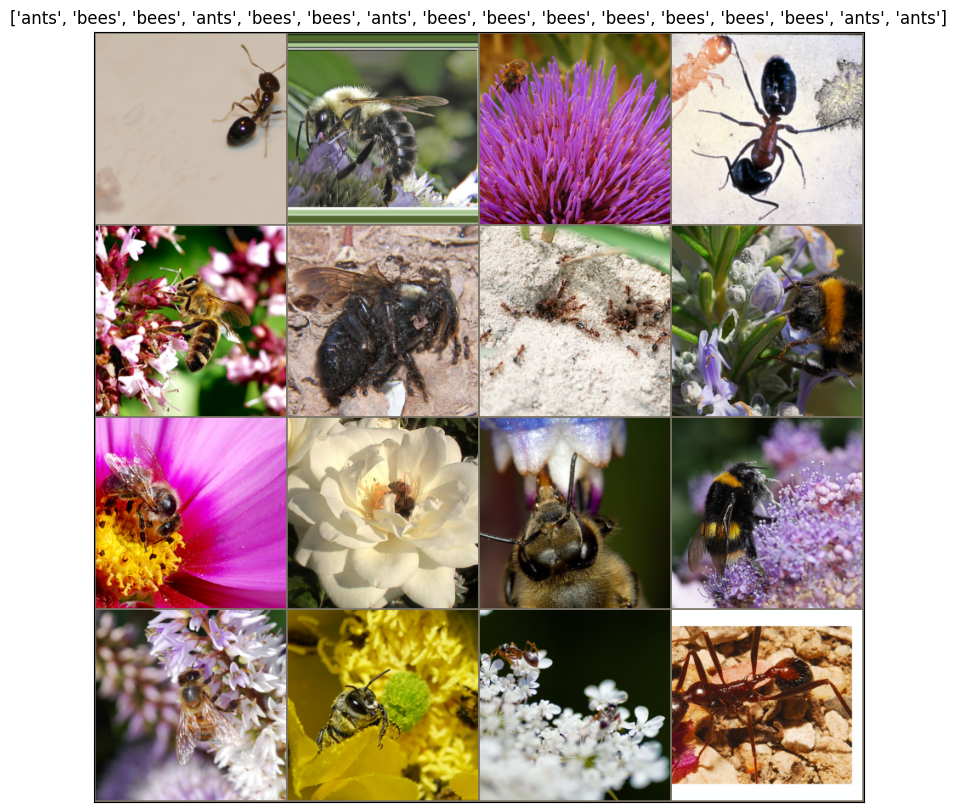

In [10]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0 , 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training dta
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
  """
  Support function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scehduler: Instance of ''torch.optim.lr_scheduler''
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs  - 1}')
    print('-' * 10)

    # Each epoch has a tarining and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() # Set model to training mode
      else:
        model.eval() # set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
          
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      
    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:.4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [32]:
def visualize_model(model, rows=3, cols=3):
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(dataloaders['val']):
      imgs = imgs.cpu()
      lbls = lbls.cpu()

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size()[0]):
        imshow(imgs.data[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title(f'predicted: {class_names[preds[jdx]]}')

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
      model.train(mode=was_training)

In [33]:
import torchvision.models.quantization as models

# You will need the number of filters in the 'fc' for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_QuantizedWeights.IMAGENET1K_FBGEMM_V1`. You can also use `weights=ResNet18_QuantizedWeights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:320: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  scal

In [34]:
from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
      model_fe.quant, # Quantize the input
      model_fe.conv1,
      model_fe.bn1,
      model_fe.relu,
      model_fe.maxpool,
      model_fe.layer1,
      model_fe.layer2,
      model_fe.layer3,
      model_fe.layer4,
      model_fe.avgpool,
      model_fe.dequant, # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
      model_fe_features,
      nn.Flatten(1),
      new_head,
  )
  return new_model


In [35]:
import torch.optim as optim

new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3998 Acc: 0.8279
val Loss: 0.2832 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.3113 Acc: 0.9139
val Loss: 0.4173 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4181 Acc: 0.9098
val Loss: 0.2954 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.5539 Acc: 0.9057
val Loss: 0.3829 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.1611 Acc: 0.9549
val Loss: 0.5488 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.2745 Acc: 0.9344
val Loss: 0.4488 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3170 Acc: 0.9180
val Loss: 0.4157 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4096 Acc: 0.9426
val Loss: 0.3791 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2304 Acc: 0.9508
val Loss: 0.3579 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2247 Acc: 0.9385
val Loss: 0.3560 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3129 Acc: 0.9303
val Loss: 0.3768 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2728 Acc: 0.9426
val Loss: 0.3452 Acc: 0.9412

Epoch 12/24
----------
t

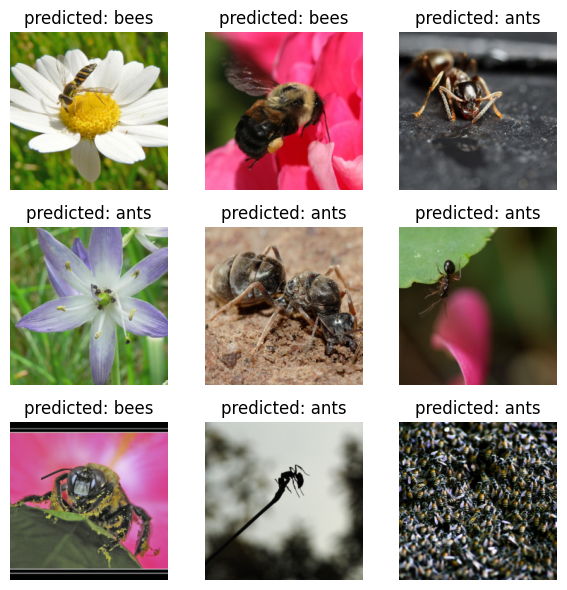

In [36]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [37]:
# notice 'quantize=False'
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# Step 1
model.train()
model.fuse_model()
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig # Use default QAT configuration
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [38]:
for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device) # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)
model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, device=device)

Epoch 0/24
----------
train Loss: 0.6177 Acc: 0.6762
val Loss: 0.3742 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.3577 Acc: 0.8320
val Loss: 0.1967 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.1746 Acc: 0.9385
val Loss: 0.2056 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.1865 Acc: 0.9098
val Loss: 0.2282 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.0998 Acc: 0.9672
val Loss: 0.1699 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.0965 Acc: 0.9713
val Loss: 0.1629 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.0769 Acc: 0.9795
val Loss: 0.1689 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.0547 Acc: 0.9877
val Loss: 0.1576 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0965 Acc: 0.9631
val Loss: 0.1403 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.0559 Acc: 0.9918
val Loss: 0.1532 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.0423 Acc: 0.9918
val Loss: 0.1719 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0771 Acc: 0.9795
val Loss: 0.1585 Acc: 0.9412

Ep

In [39]:
from torch.quantization import convert

model_ft_tuned.cpu()
model_quantized_and_trained = convert(model_ft_tuned, inplace=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


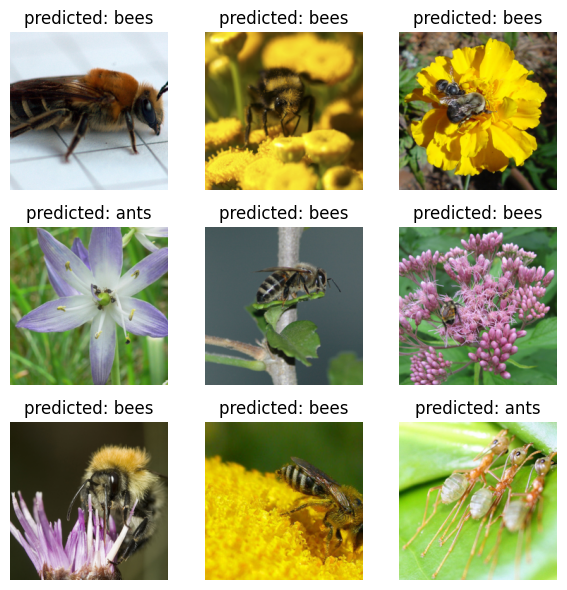

In [40]:
visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()